In [87]:
import sys, os
sys.path += ["/Users/joosep/Documents/caltech/hepaccelerate/hepaccelerate/"]

In [88]:
import glob
import numpy

import hepaccelerate
from hepaccelerate.utils import Results, Dataset, Histogram, choose_backend

import uproot
import math

import matplotlib.pyplot as plt
import numba

In [89]:
use_cuda = False
numpy_lib, ha = hepaccelerate.choose_backend(use_cuda=use_cuda)

In [90]:
datapath = "/Users/joosep/Documents/caltech/"
samplepath = "opendata/cms/MonteCarlo2016/RunIISummer16MiniAODv2/QCD_Pt-15to7000_TuneCUETP8M1_Flat_13TeV_pythia8/NANOAODSIM/PUMoriond17_magnetOn_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1/110000/"
fns = glob.glob(datapath + samplepath + "*.root")[:10]
print(len(fns), "filenames")

10 filenames


In [91]:
cols = [str(x, 'ascii') for x in uproot.open(fns[0]).get("Events").keys()]

As an example, here are all the columns for Jet objects:

In [92]:
[k for k in cols if k.startswith("Jet_")]

['Jet_area',
 'Jet_btagCMVA',
 'Jet_btagCSVV2',
 'Jet_btagDeepB',
 'Jet_btagDeepC',
 'Jet_btagDeepFlavB',
 'Jet_btagDeepFlavC',
 'Jet_chEmEF',
 'Jet_chHEF',
 'Jet_eta',
 'Jet_jercCHF',
 'Jet_jercCHPUF',
 'Jet_mass',
 'Jet_muEF',
 'Jet_muonSubtrFactor',
 'Jet_neEmEF',
 'Jet_neHEF',
 'Jet_phi',
 'Jet_pt',
 'Jet_qgl',
 'Jet_rawFactor',
 'Jet_bRegCorr',
 'Jet_bRegRes',
 'Jet_electronIdx1',
 'Jet_electronIdx2',
 'Jet_jetId',
 'Jet_muonIdx1',
 'Jet_muonIdx2',
 'Jet_nConstituents',
 'Jet_nElectrons',
 'Jet_nMuons',
 'Jet_puId',
 'Jet_genJetIdx',
 'Jet_hadronFlavour',
 'Jet_partonFlavour',
 'Jet_cleanmask']

We can load a column from the file corresponding to `Jet_pt` and inspect the contents. It is a sparse or "jagged" array.

In [93]:
jet_pt = uproot.open(fns[0]).get("Events").array("Jet_pt")
jet_pt

<JaggedArray [[83.5625 74.25 28.546875] [202.75 143.25 66.9375 26.171875 17.625] [160.25 106.4375 97.4375 ... 20.984375 20.046875 16.3125] ... [762.5 691.5 22.671875 ... 20.96875 20.6875 16.140625] [39.5625 31.625 30.3125 18.640625 18.59375 16.40625] [366.0 359.0 25.9375 17.125]] at 0x000163f05dd8>

There are approximately 100k events (rows), with approximately 6 jets per event on average.

In [94]:
jet_pt.shape[0], jet_pt.content.shape[0]

(107904, 637052)

The `content` array allows to access the raw data of all the jet pt-s.

In [95]:
jet_pt.content

array([ 83.5625  ,  74.25    ,  28.546875, ..., 359.      ,  25.9375  ,
        17.125   ], dtype=float32)

The offsets array encodes the boundaries between the events in the raw data array. Using this, we can write functions that work within the event boundaries.

In [96]:
jet_pt.offsets

array([     0,      3,      8, ..., 637042, 637048, 637052])

Now, we define which branches/columns we read from the input files and how they are grouped together to structs. For example, all the `Muon_pt`, `Muon_eta` etc branches are grouped to a Muon struct.
Quantities that are simply one value per event are listed in `EventVariables`.

In [43]:
is_mc = True
dataset_era = "2016"
dataset_name = "qcd_15to7000"

datastructures = {
    "Muon": [
        ("Muon_pt", "float32"), ("Muon_eta", "float32"),
        ("Muon_phi", "float32"), ("Muon_mass", "float32"),
        ("Muon_pdgId", "int32"),
        ("Muon_pfRelIso04_all", "float32"), ("Muon_mediumId", "bool"),
        ("Muon_tightId", "bool"), ("Muon_charge", "int32"),
        ("Muon_isGlobal", "bool"), ("Muon_isTracker", "bool"),
        ("Muon_nTrackerLayers", "int32"), ("Muon_ptErr", "float32"),
    ],
    "Electron": [
        ("Electron_pt", "float32"), ("Electron_eta", "float32"),
        ("Electron_phi", "float32"), ("Electron_mass", "float32"),
        ("Electron_pfRelIso03_all", "float32"),
        ("Electron_mvaFall17V1Iso_WP90", "bool"),
    ],
    "Jet": [
        ("Jet_pt", "float32"),
        ("Jet_eta", "float32"),
        ("Jet_phi", "float32"),
        ("Jet_mass", "float32"),
        ("Jet_btagDeepB", "float32"),
        ("Jet_qgl", "float32"),
        ("Jet_jetId", "int32"),
        ("Jet_puId", "int32"),
        ("Jet_area", "float32"),
        ("Jet_rawFactor", "float32")
    ],
    "SoftActivityJet": [
        ("SoftActivityJet_pt", "float32"),
        ("SoftActivityJet_eta", "float32"),
        ("SoftActivityJet_phi", "float32"),
    ],
    "TrigObj": [
        ("TrigObj_pt", "float32"),
        ("TrigObj_eta", "float32"),
        ("TrigObj_phi", "float32"),
        ("TrigObj_id", "int32")
    ],
    "EventVariables": [
        ("nMuon", "int32"),
        ("PV_npvsGood", "float32"), 
        ("PV_ndof", "float32"),
        ("PV_z", "float32"),
        ("Flag_BadChargedCandidateFilter", "bool"),
        ("Flag_HBHENoiseFilter", "bool"),
        ("Flag_HBHENoiseIsoFilter", "bool"),
        ("Flag_EcalDeadCellTriggerPrimitiveFilter", "bool"),
        ("Flag_goodVertices", "bool"),
        ("Flag_globalSuperTightHalo2016Filter", "bool"),
        ("Flag_BadPFMuonFilter", "bool"),
        ("Flag_BadChargedCandidateFilter", "bool"),
        ("run", "uint32"),
        ("luminosityBlock", "uint32"),
        ("event", "uint64"),
        ("SoftActivityJetNjets5", "int32"),
        ("fixedGridRhoFastjetAll", "float32"),
        ("HLT_PFJet40", "bool")
    ],
}

if is_mc:
    datastructures["EventVariables"] += [
        ("Pileup_nTrueInt", "uint32"),
        ("Generator_weight", "float32"),
        ("genWeight", "float32")
    ]
    if dataset_era == "2016" or dataset_era == "2017":
        datastructures["EventVariables"] += [
            ("L1PreFiringWeight_Nom", "float32"),
            ("L1PreFiringWeight_Dn", "float32"),
            ("L1PreFiringWeight_Up", "float32")
        ]
    datastructures["Muon"] += [
        ("Muon_genPartIdx", "int32"),
    ]
    datastructures["GenPart"] = [
        ("GenPart_pt", "float32"),
        ("GenPart_eta", "float32"),
        ("GenPart_phi", "float32"),
        ("GenPart_pdgId", "int32"),
        ("GenPart_status", "int32"),
    ]
    datastructures["Jet"] += [
        ("Jet_genJetIdx", "int32")
    ]
    datastructures["GenJet"] = [
        ("GenJet_pt", "float32"), 
        ("GenJet_eta", "float32"), 
        ("GenJet_phi", "float32"), 
        ("GenJet_mass", "float32"), 
    ]

if dataset_era == "2016":
    datastructures["EventVariables"] += [
        ("MET_pt", "float32"),
    ]
elif dataset_era == "2017":
    datastructures["EventVariables"] += [
        ("METFixEE2017_pt", "float32"),
    ]
elif dataset_era == "2018":
    datastructures["EventVariables"] += [
        ("MET_pt", "float32"),
    ]

Now we define the dataset.

In [44]:
dataset = Dataset("qcd_15to7000", fns, datastructures,
    cache_location="./mycache/", treename="Events", datapath=datapath)

We try to load the columns from an existing cache.

In [45]:
cache_exists = False
try:
    dataset.from_cache()
    cache_exists = True
    print("Cache loaded")
except FileNotFoundError as e:
    cache_exists = False
    print("Cache does not exist: {0}".format(e))

Cache does not exist: [Errno 2] No such file or directory: './mycache/opendata/cms/MonteCarlo2016/RunIISummer16MiniAODv2/QCD_Pt-15to7000_TuneCUETP8M1_Flat_13TeV_pythia8/NANOAODSIM/PUMoriond17_magnetOn_80X_mcRun2_asymptotic_2016_TrancheIV_v6-v1/110000/F4D8F740-3BEF-E611-B021-001E6750510D.HLT_PFJet40.mmap'


If the cache did not exist, we need to load the ROOT files and create the column cache.

In [46]:
if not cache_exists:
    print("Creating cache")
    dataset.load_root()
    dataset.to_cache()
    print("Done creating cache")
else:
    print("Cache exists already")

Creating cache
Done creating cache


Our dataset consists of multiple files.

In [47]:
dataset.numfiles, dataset.numevents()

(10, 876288)

Now we merge the arrays across all the files, keeping track of the event boundaries, such that we can efficiently deal with large arrays in the following kernels.

In [48]:
dataset.merge_inplace()

In [49]:
dataset.numfiles, dataset.numevents()

(1, 876288)

In [50]:
numevents = dataset.numevents()

In [51]:
print("Dataset size: {0:.2f} GB".format(dataset.memsize()/1024/1024/1024))

Dataset size: 1.21 GB


In [52]:
eventvars = dataset.eventvars[0]

In [53]:
jets = dataset.structs["Jet"][0]
jets.hepaccelerate_backend = ha

In [54]:
for i in range(5):
    j0 = jets.offsets[i]
    j1 = jets.offsets[i+1]
    pts = jets.pt[j0:j1]
    print("event={0}, njets={1}".format(i, j1-j0))
    print("pt", pts)

event=0, njets=3
pt [83.5625   74.25     28.546875]
event=1, njets=5
pt [202.75     143.25      66.9375    26.171875  17.625   ]
event=2, njets=10
pt [160.25     106.4375    97.4375    66.0625    49.75      27.15625
  26.265625  20.984375  20.046875  16.3125  ]
event=3, njets=5
pt [354.75   249.75   167.75   109.4375  27.375 ]
event=4, njets=1
pt [23.34375]


In [55]:
muons = dataset.structs["Muon"][0]

In [59]:
def select_events(eventvars):
    pass_trigger = eventvars["HLT_PFJet40"] == True
    pass_flags = eventvars["Flag_goodVertices"] == True
    return pass_trigger & pass_flags

In [60]:
def select_jets(jets, muons, mask_events, mask_muons, ptcut=30, ptcut_leading=40):
    mask_jets = numpy_lib.ones(jets.numobjects(), dtype=numpy_lib.bool)
    mask_jets = mask_jets & (jets.pt > ptcut)
    pass_lepton_dr = ha.mask_deltar_first(jets, mask_jets, muons, mask_muons, 0.5)
    mask_jets = mask_jets & pass_lepton_dr
    return mask_jets

In [ ]:
def to_spherical(arrs):
    px = arrs["px"]
    py = arrs["py"]
    pz = arrs["pz"]
    e = arrs["e"]
    pt = NUMPY_LIB.sqrt(px**2 + py**2)
    eta = NUMPY_LIB.arcsinh(pz / pt)
    phi = NUMPY_LIB.arccos(NUMPY_LIB.clip(px / pt, -1.0, 1.0))
    mass = NUMPY_LIB.sqrt(NUMPY_LIB.abs(e**2 - (px**2 + py**2 + pz**2)))
    rap = rapidity(e, pz)
    return {"pt": pt, "eta": eta, "phi": phi, "mass": mass, "rapidity": rap}

In [ ]:
def deltar(obj1, obj2, use_cuda):
    deta = obj1["eta"] - obj2["eta"]
    dphi = NUMPY_LIB.zeros(len(deta), dtype=NUMPY_LIB.float32)
    if use_cuda:
        deltaphi_cudakernel[21,1024](obj1["phi"],obj2["phi"],dphi)
        cuda.synchronize()
    else:
        deltaphi_cpu(obj1["phi"],obj2["phi"],dphi)
    dr = NUMPY_LIB.sqrt(deta**2 + dphi**2)
    return deta, dphi, dr 

In [83]:
@numba.njit('float32[:], float32[:], float32[:]', parallel=True, fastmath=True)
def deltaphi_cpu(phi1, phi2, out_dphi):
    for iev in numba.prange(len(phi1)):
        dphi = phi1[iev] - phi2[iev] 
        if dphi > math.pi:
            dphi = dphi - 2*math.pi
            out_dphi[iev] = dphi
        elif (dphi + math.pi) < 0:
            dphi = dphi + 2*math.pi
            out_dphi[iev] = dphi
        else:
            out_dphi[iev] = dphi

if use_cuda:
    @cuda.jit
    def deltaphi_cudakernel(phi1, phi2, out_dphi):
        xi = cuda.grid(1)
        xstride = cuda.gridsize(1)

        for iev in range(xi, len(phi1), xstride):
            dphi = phi1[iev] - phi2[iev] 
            if dphi > math.pi:
                dphi = dphi - 2*math.pi
                out_dphi[iev] = dphi
            elif (dphi + math.pi) < 0:
                dphi = dphi + 2*math.pi
                out_dphi[iev] = dphi
            else:
                out_dphi[iev] = dphi

In [84]:
def dnn_variables(leading_lepton, subleading_lepton, leading_jet, subleading_jet, nsoft, use_cuda, NUMPY_LIB):
    #delta eta, phi and R between two muons
    mm_deta, mm_dphi, mm_dr = deltar(leading_lepton, subleading_lepton, use_cuda)
    
    #delta eta between jets 
    jj_deta = leading_jet["eta"] - subleading_jet["eta"]
    jj_dphi = leading_jet["phi"] - subleading_jet["phi"]
    jj_dphi_mod = NUMPY_LIB.zeros(len(jj_dphi), dtype=NUMPY_LIB.float32)

    if use_cuda:
        deltaphi_cudakernel[32,1024](leading_jet["phi"],subleading_jet["phi"], jj_dphi_mod)
        cuda.synchronize()
    else:
        deltaphi_cpu(leading_jet["phi"],subleading_jet["phi"], jj_dphi_mod)

    #jj_dphi_mod = NUMPY_LIB.mod(jj_dphi + math.pi, math.pi)
    
    #muons in cartesian, create dimuon system 
    m1 = to_cartesian(leading_lepton)    
    m2 = to_cartesian(subleading_lepton)    
    mm = {k: m1[k] + m2[k] for k in ["px", "py", "pz", "e"]}
    mm_sph = to_spherical(mm)

    #jets in cartesian, create dijet system 
    j1 = to_cartesian(leading_jet)
    j2 = to_cartesian(subleading_jet)
    leading_jet["rapidity"] = rapidity(j1["e"], j1["pz"]) 
    subleading_jet["rapidity"] = rapidity(j2["e"], j2["pz"]) 
    jj = {k: j1[k] + j2[k] for k in ["px", "py", "pz", "e"]}
    jj_sph = to_spherical(jj)
  
    #create dimuon-dijet system 
    mmjj = {k: j1[k] + j2[k] + m1[k] + m2[k] for k in ["px", "py", "pz", "e"]} 
    mmjj_sph = to_spherical(mmjj)
    #compute deletaEta between Higgs and jet
    EtaHQs = []
    for jet in [leading_jet, subleading_jet]:
        EtaHQ = mm_sph["eta"] - jet["eta"] 
        EtaHQs += [EtaHQ]
    EtaHQ = NUMPY_LIB.vstack(EtaHQs)
    minEtaHQ = NUMPY_LIB.min(EtaHQ, axis=0)
    #compute deltaR between all muons and jets
    dr_mjs = []
    for mu in [leading_lepton, subleading_lepton]:
        for jet in [leading_jet, subleading_jet]:
            _, _, dr_mj = deltar(mu, jet, use_cuda)
            dr_mjs += [dr_mj]
    dr_mj = NUMPY_LIB.vstack(dr_mjs)
    dRmin_mj = NUMPY_LIB.min(dr_mj, axis=0) 
    dRmax_mj = NUMPY_LIB.max(dr_mj, axis=0) 
    #compute deltaR between dimuon system and both jets 
    dr_mmjs = []
    for jet in [leading_jet, subleading_jet]:
        _, _, dr_mmj = deltar(mm_sph, jet, use_cuda)
        dr_mmjs += [dr_mmj]
    dr_mmj = NUMPY_LIB.vstack(dr_mmjs)
    dRmin_mmj = NUMPY_LIB.min(dr_mmj, axis=0) 
    dRmax_mmj = NUMPY_LIB.max(dr_mmj, axis=0)
   
    #Zeppenfeld variable
    Zep = (mm_sph["eta"] - 0.5*(leading_jet["eta"] + subleading_jet["eta"]))
    Zep_rapidity = (mm_sph["rapidity"] - 0.5*(leading_jet["rapidity"] + subleading_jet["rapidity"]))/(leading_jet["rapidity"]-subleading_jet["rapidity"])

    #Collin-Soper frame variable
    cthetaCS = 2*(m1["pz"] * m2["e"] - m1["e"]*m2["pz"]) / (mm_sph["mass"] * NUMPY_LIB.sqrt(NUMPY_LIB.power(mm_sph["mass"], 2) + NUMPY_LIB.power(mm_sph["pt"], 2)))

    ret = {
        #"leading_muon_pt": leading_muon["pt"],
        #"leading_muon_eta": leading_muon["eta"],
        #"leading_muon_phi": leading_muon["phi"],
        #"leading_muon_mass": leading_muon["mass"],
        #"subleading_muon_pt": subleading_muon["pt"],
        #"subleading_muon_eta": subleading_muon["eta"],
        #"subleading_muon_phi": subleading_muon["phi"],
        #"subleading_muon_mass": subleading_muon["mass"],
        "dEtamm": mm_deta, "dPhimm": mm_dphi, "dRmm": mm_dr,
        "M_jj": jj_sph["mass"], "pt_jj": jj_sph["pt"], "eta_jj": jj_sph["eta"], "phi_jj": jj_sph["phi"],
        "M_mmjj": mmjj_sph["mass"], "eta_mmjj": mmjj_sph["eta"], "phi_mmjj": mmjj_sph["phi"],
        "dEta_jj": jj_deta,
        "dEta_jj_abs": NUMPY_LIB.abs(jj_deta),
        "dPhi_jj": jj_dphi,
        "dPhi_jj_mod": jj_dphi_mod,
        "dPhi_jj_mod_abs": NUMPY_LIB.abs(jj_dphi_mod),
        "leadingJet_pt": leading_jet["pt"],
        "subleadingJet_pt": subleading_jet["pt"],
        "leadingJet_eta": leading_jet["eta"],
        "subleadingJet_eta": subleading_jet["eta"],
        "dRmin_mj": dRmin_mj,
        "dRmax_mj": dRmax_mj,
        "dRmin_mmj": dRmin_mmj,
        "dRmax_mmj": dRmax_mmj,
        "Zep": Zep,
        "Zep_rapidity": Zep_rapidity,
        "leadingJet_qgl": leading_jet["qgl"],
        "subleadingJet_qgl": subleading_jet["qgl"], 
        "cthetaCS": cthetaCS,
        "softJet5": nsoft,
        "Higgs_pt": mm_sph["pt"],
        "Higgs_eta": mm_sph["eta"],
        "Higgs_rapidity": mm_sph["rapidity"],
        "Higgs_mass": mm_sph["mass"],
        #DNN pisa variable
        "Mqq_log": NUMPY_LIB.log(jj_sph["mass"] ),
        "Rpt": mmjj_sph["pt"]/(mm_sph["pt"]+jj_sph["pt"]),
        "qqDeltaEta": NUMPY_LIB.abs(jj_deta),
        "ll_zstar": NUMPY_LIB.abs(mm_sph["rapidity"] - 0.5*(leading_jet["rapidity"] + subleading_jet["rapidity"]))/(leading_jet["rapidity"]-subleading_jet["rapidity"]),
        "NSoft5": nsoft,
        "minEtaHQ": minEtaHQ,
        "log(Higgs_pt)": NUMPY_LIB.log(mm_sph["pt"]),
        "Mqq": jj_sph["mass"],
        "QJet0_pt_touse": leading_jet["pt"],
        "QJet1_pt_touse": subleading_jet["pt"],
        "QJet0_eta": leading_jet["eta"],
        "QJet1_eta": subleading_jet["eta"],
        "QJet0_phi": leading_jet["phi"],
        "QJet1_phi": subleading_jet["phi"],
        "QJet0_qgl": leading_jet["qgl"],
        "QJet1_qgl": subleading_jet["qgl"],
        "Higgs_m": mm_sph["mass"],
    }

    if debug:
        for k in ret.keys():
            msk = NUMPY_LIB.isnan(ret[k])
            if NUMPY_LIB.sum(msk) > 0:
                print("dnn vars nan", k, np.sum(msk))

    return ret

In [61]:
mask_events = select_events(eventvars)
mask_muons = muons.pt>20

In [62]:
mask_jets = select_jets(jets, muons, mask_events, mask_muons)

In [86]:
dataset.structs["Electron"][0]

JaggedStruct(prefix=Electron_, numevents=876288, numobjects=460021, attrs_data=
{'pt': array([48.65482  ,  8.609233 ,  5.6734905, ..., 22.74225  ,  7.7119923,
       77.95967  ], dtype=float32), 'eta': array([ 1.8034668 , -0.80737305, -2.2470703 , ...,  0.04047394,
       -0.10690308,  0.49804688], dtype=float32), 'phi': array([-2.2631836 , -2.364746  , -1.8308105 , ..., -1.0390625 ,
       -0.9884033 ,  0.25238037], dtype=float32), 'mass': array([ 0.01818848,  0.00077915,  0.00860596, ..., -0.00608826,
        0.00222778, -0.02905273], dtype=float32), 'pfRelIso03_all': array([0.9614071, 6.7830243, 2.3812408, ..., 2.5217996, 8.419148 ,
       1.7697215], dtype=float32), 'mvaFall17V1Iso_WP90': array([False, False, False, ..., False, False, False])})

In [63]:
inds = numpy_lib.zeros(jets.numevents(), dtype=numpy_lib.int32)
inds[:] = 0
leading_jet_pt = ha.get_in_offsets(jets.pt, jets.offsets, inds, mask_events, mask_jets)

mask_events = mask_events & (leading_jet_pt > 40)

njet = ha.sum_in_offsets(jets, mask_jets, mask_events, mask_jets, numpy_lib.int8)
events_2jet = njet==2
events_3jet = njet==3

In [64]:
genweights_jet = numpy_lib.zeros(jets.numobjects(), dtype=numpy_lib.float32)
ha.broadcast(dataset.eventvars[0]["genWeight"], jets.offsets, genweights_jet)

In [65]:
bins = numpy_lib.linspace(0,500,100)

In [66]:
out_w = numpy_lib.zeros(len(bins)-1, dtype=numpy_lib.float32)
out_w2 = numpy_lib.zeros(len(bins)-1, dtype=numpy_lib.float32)

In [67]:
ha.fill_histogram(jets.pt[mask_jets], genweights_jet[mask_jets], bins, out_w, out_w2)

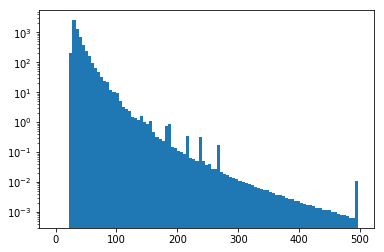

In [68]:
plt.bar(bins[:-1], out_w, bins[1]-bins[0]);
plt.yscale("log")

In [69]:
jet0 = jets.select_nth(0, mask_events, mask_jets, ["pt", "eta", "phi"])
jet1 = jets.select_nth(1, mask_events, mask_jets, ["pt", "eta", "phi"])
jet2 = jets.select_nth(2, mask_events, mask_jets, ["pt", "eta", "phi"])

In [70]:
deta01_2j = jet0["eta"][events_2jet] - jet1["eta"][events_2jet]

dphi01_2j = jet0["phi"][events_2jet] - jet1["phi"][events_2jet]

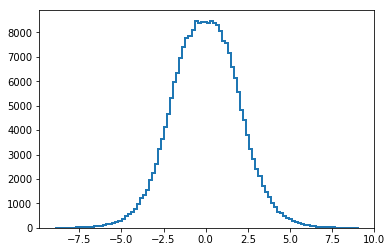

In [71]:
plt.hist(deta01_2j, bins=100, histtype="step", lw=2);

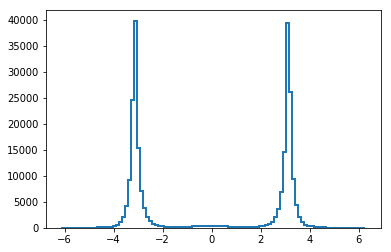

In [72]:
plt.hist(dphi01_2j, bins=100, histtype="step", lw=2);

In [73]:
deta01_3j = jet0["eta"][events_3jet] - jet1["eta"][events_3jet]
deta02_3j = jet0["eta"][events_3jet] - jet2["eta"][events_3jet]
deta12_3j = jet1["eta"][events_3jet] - jet2["eta"][events_3jet]


dphi01_3j = jet0["phi"][events_3jet] - jet1["phi"][events_3jet]
dphi02_3j = jet0["phi"][events_3jet] - jet2["phi"][events_3jet]
dphi12_3j = jet1["phi"][events_3jet] - jet2["phi"][events_3jet]

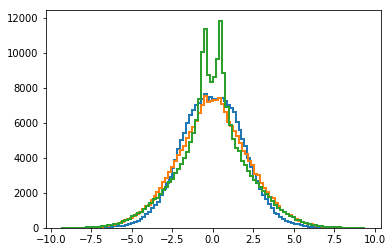

In [74]:
plt.hist(deta01_3j, bins=100, histtype="step", lw=2);
plt.hist(deta02_3j, bins=100, histtype="step", lw=2);
plt.hist(deta12_3j, bins=100, histtype="step", lw=2);

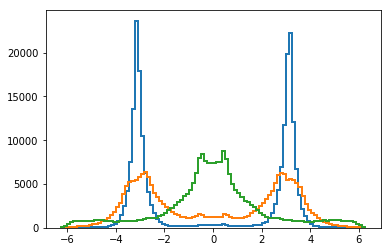

In [75]:
plt.hist(dphi01_3j, bins=100, histtype="step", lw=2);
plt.hist(dphi02_3j, bins=100, histtype="step", lw=2);
plt.hist(dphi12_3j, bins=100, histtype="step", lw=2);

In [76]:
bins = numpy_lib.linspace(30, 330, 100)

In [77]:
ha.searchsorted(bins, jets.pt[mask_jets], "left")

array([18, 15, 58, ...,  7, 50, 45], dtype=int32)

In [ ]:
#!rm -f ../kernel_benchmarks.txt

In [ ]:
# !cd .. && PYTHONPATH=. NUMBA_NUM_THREADS=1 OMP_NUM_THREADS=1 python3 tests/kernel_test.py
# !cd .. && PYTHONPATH=. NUMBA_NUM_THREADS=2 OMP_NUM_THREADS=2 python3 tests/kernel_test.py
# !cd .. && PYTHONPATH=. NUMBA_NUM_THREADS=3 OMP_NUM_THREADS=3 python3 tests/kernel_test.py
# !cd .. && PYTHONPATH=. NUMBA_NUM_THREADS=4 OMP_NUM_THREADS=4 python3 tests/kernel_test.py

In [ ]:
# !cat ../kernel_benchmarks.txt